#Table of Contents
* [1. Inicialização](#1.-Inicialização)
* [2. Execução](#2.-Execução)
* [3. Salvar resultados](#3.-Salvar-resultados)


# 1. Inicialização

In [30]:
%pylab inline
import zap_util as z
import statsmodels.api as sm
from sklearn import cross_validation as cv
import IPython
z.set_style()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [31]:
# Método para salvar os resultados em uma pasta específica.
import os

def save_results(folder, name, lm_result):
    for ext in ['txt','tex','bin']:
        dir_folder = '{}/{}'.format(folder,ext)
        if not os.path.isdir(dir_folder):
            os.makedirs(dir_folder)
        fname = '{}/{}.{}'.format(dir_folder,name,ext)
        with open(fname,'w') as f:
            if ext == 'txt':
                f.write(lm_result.summary().as_text())
            elif ext == 'text':
                f.write(lm_result.summary().as_latex())
            elif ext == 'bin':
                lm_result.save(fname)    
    
def vars_constants(dataframe):
    x = dataframe.apply(lambda x: len(x.unique()), axis=0)
    return x[x==1].index.tolist()

# 2. Execução

In [32]:
# Carrega datafram somente com imóveis já tratados.
df = z.get_imoveis_dataframe(False)
nome_bairros = df.bairro_g.unique()
nome_bairros.sort()
count_bairros = df.bairro_g.value_counts()
idx_bairro = df.bairro_g.copy()
df = z.prep_statsmodels(df,False)
del df['bairro_g']

df.shape


(28111, 75)

In [33]:
preco_lag = True
if preco_lag:
    reload(z)
    import pysal
    w = z.getW()
    df['preco_lag'] = pysal.lag_spatial(w,df.preco)
    df.shape

In [34]:
%%time
# 3min

# Variáveis a serem tratadas como categóricas.
#vars_catgr = ['suites','quartos','garagem']
#vars_ignore = ['preco','condominio','m2','bairro_g'] + vars_catgr
#n_vars_ignore = len(vars_ignore)

# Remover variáveis constantes globais.

# Execução das regressões.
score = []
k=1
n = len(nome_bairros)
bairros_low = []
bairros_erro = []
for b in nome_bairros:
    print('Processando {} de {}: {}.'.format(k,n,b))
    k+=1
    dfb = df.loc[idx_bairro == b].copy()

    '''
    # Tratar variáveis categóricas.
    for var_ in vars_catgr:
        dfcat = z.pd.get_dummies(dfb[var_])
        del dfcat[dfcat.columns.tolist()[0]]
        dfcat.columns = [var_+'_'+str(int(i)) for i 
                         in dfcat.columns.tolist()]
        dfb = z.pd.concat([dfb, dfcat], axis=1)
   '''
    # Remover variáveis constantes.
    const = vars_constants(dfb)    
    for i in const:
        del dfb[i]

    
    # Verifica se dataset de bairro tem observações suficientes.
    if (len(dfb)>0) and (len(dfb)> len(dfb.columns)-1):
        try:
            lm,_,_= z.ols(dfb, [], [], 
                avoid_corr=True, avoid_plow=True, 
                remove_plow_by_step=True)

            # Avaliação do modelo. Salva os seguintes resultados:
            # bairro, rmse, r2,tamanho, variáveis,mean(preco)
            # median(preco),mean(preco_lag),median(preco_lag)
            score.append([
                b, z.rmse(lm.resid),lm.rsquared,
                len(dfb),len(lm.params)-1,
                mean(dfb.preco),median(dfb.preco)
                #,mean(dfb.preco_lag),median(dfb.preco_lag)
                ])
            save_results('./modelos_bairro', b, lm)
        except Exception as E:
            print 'ERRO ao processar: {} \n {}'.format(b,E)
            bairros_erro.append(b)
    else:
        bairros_low.append(b)
IPython.display.clear_output()

print 'FIM'

FIM
CPU times: user 1min 50s, sys: 1.47 s, total: 1min 51s
Wall time: 1min 55s


In [23]:
count_bairros_low = count_bairros[count_bairros.index.isin(bairros_low)]
count_bairros_low = count_bairros_low.sort_index();

In [24]:
print 'Total: {}. Com modelo: {}. Sem modelo: {}'.format(
    count_bairros.shape[0],len(score),count_bairros_low.shape[0])

Total: 155. Com modelo: 73. Sem modelo: 76


In [25]:
str_bairros_low = ', '.join(['{}({})'.format(k[0],k[1]) for k in 
           [i for i in count_bairros_low.iteritems()]])
with open('../texto/tex/bairros_baixo_m.tex','w') as f:
    f.write(str_bairros_low)
print str_bairros_low

Abolicao(42), Agua Santa(39), Alto da Boa Vista(36), Anchieta(3), Bancarios(18), Bangu(18), Barra de Guaratiba(2), Barros Filho(8), Benfica(15), Bento Ribeiro(25), Cacuia(30), Caju(5), Campinho(30), Campo dos Afonsos(7), Catumbi(26), Cavalcanti(8), Cidade Nova(25), Cidade Universitaria(5), Cidade de Deus(24), Cocota(24), Coelho Neto(10), Colegio(20), Complexo do Alemao(7), Cordovil(26), Cosmos(31), Costa Barros(16), Deodoro(2), Engenho da Rainha(30), Galeao(10), Gamboa(9), Gardenia Azul(16), Guadalupe(10), Guaratiba(15), Honorio Gurgel(6), Inhauma(32), Inhoaiba(18), Itanhanga(48), Jacare(17), Jacarezinho(4), Jardim America(13), Joa(2), Magalhaes Bastos(5), Manguinhos(3), Mare(5), Marechal Hermes(20), Maria da Graca(33), Monero(26), Osvaldo Cruz(18), Paciencia(12), Padre Miguel(7), Parada de Lucas(7), Pavuna(25), Pilares(33), Pitangueiras(34), Praia da Bandeira(36), Realengo(26), Ribeira(38), Rocha Miranda(18), Rocinha(5), Santa Cruz(35), Santissimo(6), Santo Cristo(12), Senador Camara(

In [26]:
print '{} bairros com erro ao processar: '.format(len(bairros_erro))\
    + ', '.join(bairros_erro)

6 bairros com erro ao processar: Acari, Mangueira, Parque Anchieta, Pedra de Guaratiba, Ricardo de Albuquerque, Vila Militar


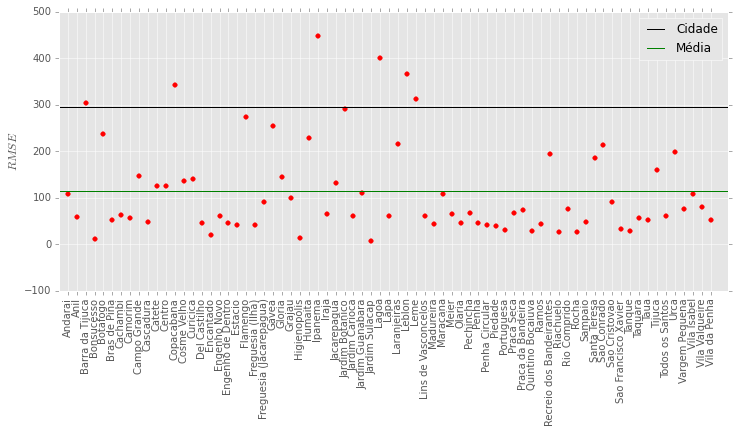

In [27]:
def plot_score(lm_score):

    x_name = []
    y_test = []
    y_train = []
    for i in range(len(lm_score)):
        x_name.append(lm_score[i][0])
        y_train.append(lm_score[i][1])
        y_test.append(NaN)
    fig,ax = subplots()
    ax.scatter(range(len(x_name)), y_train,color='r');
    ax.set_ylabel(r'$RMSE$')
    xticks(range(len(x_name)), x_name, rotation=90);
    axhline(y=295.1687623761913, color='black', label='Cidade');
    axhline(y=mean(y_train), color='green', label=u'Média');
    legend();
    xlim(-1,len(x_name)+1);

figsize(12,5)
plot_score(score)

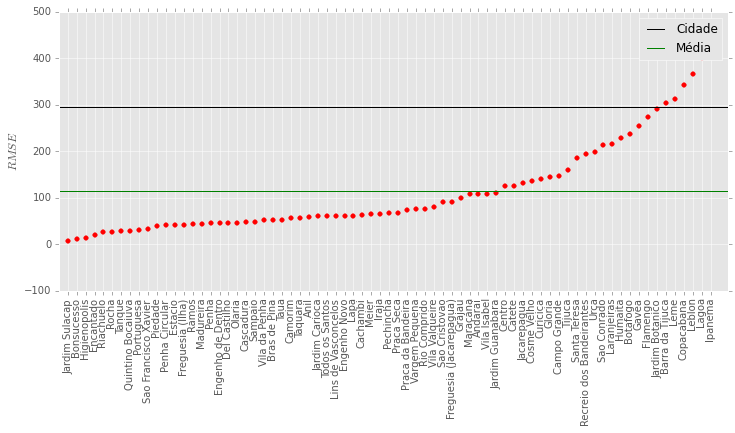

In [28]:
plot_score(sorted(score, key=lambda x: x[1]))

# 3. Salvar resultados

In [29]:
# bairro, rmse, r2, tamanho, variáveis, mean(preco)
# median(preco), mean(preco_lag), median(preco_lag)

dfx = z.pd.DataFrame(score, 
    columns=['Bairro', 'RMSE','R2','m','n',
             'MediaPreco','MedianaPreco'
            # ,'MediaLag','MedianaLag']
            ])
dfx.to_csv('../ipython_notebook/modelos_bairro/score_bairros.csv', 
    index=False)
